# Semi-Supervised Learning

## Contents

The Datasets used for this tutorial can be found here:


--------

## Introduction

<p align="center">
    <img src="semi_supervised_images/ssl1.png" width="400"/>
</p>

Semi Supervised Learning, 즉 준지도학습은 적은 양의 labeled 데이터와 많은 양의 unlabeled 데이터가 있다면 unlabeled 데이터 까지 활용하여 모델을 학습하는 방법론들의 집합이다.

준지도학습에서는 데이터의 본질적인 특성이 모델링 된다면, 소량의 labeled 데이터를 약간의 가이드 형식으로만 활용하여 전체적인 일반화 성능을 끌어올릴 수 있다는 전제를 두고 있다. 그렇기에 대부분의 준지도학습 모델의 손실함수는 두개의 term 이 결합된 형태이다.

$$
L = L_{supervised} + L_{unsupervised}
$$

데이터의 본질적인 특성의 모델링을 통한 성능향상 방법론이기에, 먼저 데이터에 대한 몇가지 가정이 필요하다.

1. Smoothness Assumption

    만약 데이터스페이스 상에서 두 샘플 $x_1, x_2$ 가 가깝다면, 이에 대응하는 정답 label $y_1, y_2$ 또한 가깝다.

2. Cluster Assumption

    데이터스페이스에는 높은 density 를 가진 영역과 낮은 density 를 가진 영역이 존재한다. 높은 density 를 가진 영역에는 대게 같은 label 을 가진 샘플들이 군집되어있다.

3. Low Density Assumption

    두개의 클래스를 구분짓는 분류경계면은 낮은 density region 을 통과한다. SVM 에서 Margin 을 최대화 하는 분류경계면을 최적의 경계면으로 채택하는 개념과 일맥상통한다.

4. Manifold Assumption

    고차원의 데이터의 특성을 그대로 유지하는 저차원의 manifold 가 존재한다.

**이 중에서 가장 중요한 가정을 고르자면 모든 가정을 관통하는 Smoothness Assumption 이다.**

## Consistency Regularization Methods

준지도학습의 taxonomy 를 확인해보면 GAN based 생성모델 기반 학습, Graph 기반 학습 등 다양한 갈래가 존재하지만, 해당 튜토리얼은 Consistency Regularization Methods 을 다루고자 한다.

Consistency Regularization Methods 는 이미지 도메인에서 많이 쓰이는 준지도학습 방법론들이며, unlabeled 샘플에 작은 perturbation 을 주어도 모델 자체의 예측은 일관성이 있을 거라는 가정 하에 출발한다.

그렇기에 labeled 샘플에 대해서는 일반적으로 잘 맞추도록 학습되며, unlabeled 샘플에 대해서는 약간의 perturbation 을 준 샘플과 차이가 크지 않도록 학습이 된다. 이때 labeled 샘플에 대해서는 cross entropy 와 같은 일반적인 지도학습 손실함수가 사용되며, unlabeled 샘플에 대해서는 MSE, KL Divergence, Jensen Shannon Divergence 등 minimizing term 손실함수가 사용된다.

### Pi-Model


<p align="center">
    <img src="semi_supervised_images/piarchitecture.png" width="400"/>
</p>

Pi Model 은 2017년 ICLR 에서 소개된 방법론이며, Consistency Regularization 의 큰 개념을 설명하는데 가장 적합하다 판단하여 먼저 다루고자 한다.

> 본 논문에서는 특이하게도 output 을 $z_i$ 라고 표기하며, 샘플 $x_i$ 에 대한 정답 label 을 $y_i$ 로 표기한다. Perturbation 이 가해진 객체는 $\tilde{z}$ 로 표기한다.

네트워크 구조는 위와 같으며, 인풋 샘플에 대해 주는 stochastic augmentation (perturbation) 이 핵심이다. 각 Batch 기준으로 모델이 학습되는 원리는 다음과 같다.

#### Training of the Pi-Model

1. 하나의 샘플에 대해 아주 작은 perturbation 을 준 두개의 샘플을 생성한다.
2. 두개의 샘플을 같은 네트워크에 통과시킨다. 이때, 네트워크는 하나이지만 (같은 parameter) 각 샘플이 통과될 때 다른 dropout 이 적용된다.
3. 두개의 샘플에 대한 두개의 모델의 예측 pair $(x_i, z_i), (\tilde{x_i}, \tilde{z_i})$ 을 생성한다.
4. 둘중 아무 쌍 $(x_i, z_i)$ 이나 이용해서 supervised loss 를 계산하고, 두 쌍의 output $(z_i, \tilde{z_i})$ 을 통해 unsupervised loss 를 계산한 뒤, parameter 을 업데이트 한다. 이때 supervised loss 는 해당 batch 안에 있는 labeled 샘플에 대해서만 계산이 되며 ($B \cap L$), unsupervised loss 는 batch 속 모든 샘플에 대해서 계산이 된다.

<p align="center">
    <img src="semi_supervised_images/pialg.png" width="400"/>
</p>

이때 supervised loss 는 cross entropy 를 사용하며, unsupervised loss 는 MSE 를 사용한다.

실제로 loss 가 계산되는 term 을 확인해보면 cross entropy 와 MSE 의 결합으로 계산되는데, unsupervised weigth ramp up function $w(t)$ 이라는 term 이 MSE를 scaling 하는 것을 확인 할 수 있다. 이 weight ramp up function 은 단조증가하는 임의의 함수이며, 학습 시작점에선 0에 근접한다.

다른 dropout 과 perturbation (gaussian) 을 사용했기 때문에 두개의 output $(z_i, \tilde{z_i})$ 은 다르지만, 실제론 굉장히 가깝기에 MSE 를 계산하는것이 일리가 있다.

#### Limitations of the Pi-Model

Unsupervised loss 는 모델의 두 output $(z_i, \tilde{z_i})$ 에 대해 계산된다. 하지만 해당 output 은 단 한번의 evaluation 을 통해 생성되기 때문에 (초기엔 더더욱) noisy 하다는 단점이 있다. 그렇기에 Pi-Model 의 저자들이 동 논문에서 단점들을 보완한 Temporal Ensembling 을 제안한다.

### Temporal Ensembling

<p align="center">
    <img src="semi_supervised_images/tempensarchitecture.png" width="400"/>
</p>


Temporal Ensembling 과 Pi-Model 의 차이점은 unsupervised loss 를 계산하는 방법에서 확인 할 수 있다. Pi-Model 은 하나의 샘플에 대해 두번의 perturbation 을 주어 두개의 output $(z_i, \tilde{z_i})$ 사이의 loss 를 계산하지만, **Temporal Ensembling 은 해당 단계의 output $z_i$ 를 이전 단계들에서 구한 $z_i$ 의 가중합 사이의 loss 를 계산한다.**

즉, 특정 단계에서 MSE 를 구할 땐 해당 단계에서의 output $z_i$ 와, 이전 단계들에서 누적된 $Z$ 사이의 차이를 계산한다.

이때, $Z$ 는 $Z \leftarrow \alpha Z + (1-\alpha)z$ 로 누적되며, $\alpha$ 는 momentum term 으로, 본 논문에선 $\alpha=0.6$ 으로 설정된다.

<p align="center">
    <img src="semi_supervised_images/tempensalg.png" width="400"/>
</p>


#### Temporal Ensembling: Code Implementation

In [130]:
import os
import platform
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import scienceplots
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

plt.style.use(['science', 'notebook', 'grid'])

if platform.system() == 'Darwin':
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Operating system: {platform.system()}, Device: {device}')

Operating system: Darwin, Device: mps


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


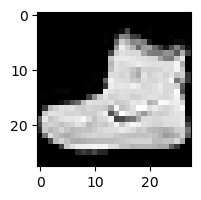

In [35]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transform,
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transform
)

sample_img = train_data[0][0]
plt.figure(figsize=(2,2))
plt.imshow(sample_img.permute(1,2,0), cmap='gray');

class_names = train_data.classes
class_dict = train_data.class_to_idx
print(class_dict)

사용한 데이터셋은 10개의 패션 아이템을 모아둔 FashionMNIST다.

In [163]:
n = len(train_data)  # 60000 for mnist
rrng = np.random.RandomState(42)
indices = torch.zeros(100)  # indices of keep labeled data
others = torch.zeros(n - 100)  # indices of unlabeled data
card = 100 // len(class_names)  # number of samples per class
cpt = 0

for i in range(len(class_names)):
    class_items = (train_data.train_labels == i).nonzero()  # indices of samples with label i
    n_class = len(class_items)  # number of samples with label i
    rd = rrng.permutation(np.arange(n_class))  # shuffle them
    indices[i * card: (i+1) * card] = torch.squeeze(class_items[rd[:card]])
    others[cpt: cpt+n_class-card] = torch.squeeze(class_items[rd[card:]])
    cpt += (n_class-card)

# tensor as indices must be long, byte or bool
others = others.long()
train_data.train_labels[others] = -1

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                            batch_size=64,
                                            num_workers=2,
                                            shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                            batch_size=64,
                                            num_workers=4,
                                            shuffle=False,
                                            drop_last=True)

In [54]:
no_label_train = [i for i in train_data.targets if i == -1]
no_label_test = [i for i in test_data.targets if i == -1]
print(f'Number of unlabeled samples in train data: {len(no_label_train)}')
print(f'Number of unlabeled samples in test data: {len(no_label_test)}')

Number of unlabeled samples in train data: 59900
Number of unlabeled samples in test data: 0


FashionMNIST 데이터는 60,000개의 학습 샘플과 10,000개의 테스트 샘플을 가지고 있다. 기본적으로 모든 샘플들에는 레이블이 존재하기 때문에, 임의로 학습 샘플 중 100개의 샘플만 남겨두고 나머지 59,900 개의 샘플들의 레이블을 `-1`, 즉 unlabeled 데이터로 변환하였다.

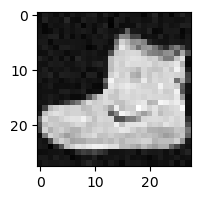

In [73]:
class GaussianNoise(nn.Module):
    def __init__(self, batch_size, input_shape, std):
        super(GaussianNoise, self).__init__()
        self.shape = (batch_size, ) + input_shape
        self.std = std
        self.noise = torch.zeros(self.shape)

    def forward(self, x):
        self.noise.normal_(mean=0, std=self.std)
        return x + self.noise
gn = GaussianNoise(1, (1, 28, 28), 0.1)
sample_perturbed_img = gn(sample_img).squeeze()
plt.figure(figsize=(2,2))
plt.imshow(sample_perturbed_img, cmap='gray');

각 input sample 에 가우시안 perturbation 을 줄 class 를 정의하였다.

In [85]:
def mse_loss(out1, out2):
    quad_diff = torch.sum((F.softmax(out1, dim=1) - F.softmax(out2, dim=1)) ** 2)
    return quad_diff / out1.data.nelement()

def masked_crossentropy(out, labels):
    cond = (labels >= 0)
    nnz = torch.nonzero(cond)
    nbsup = len(nnz)
    if nbsup > 0:
        masked_outputs = torch.index_select(out, 0, nnz.view(nbsup))
        masked_labels = labels[cond]
        loss = F.cross_entropy(masked_outputs, masked_labels)
        return loss, nbsup
    loss = torch.tensor([0.], requires_grad=False)
    return loss, 0

def temporal_losses(out1, out2, w, labels):
    sup_loss, nbsup = masked_crossentropy(out1, labels)
    unsup_loss = mse_loss(out1, out2)
    total_loss = sup_loss + w * unsup_loss
    return total_loss, sup_loss, unsup_loss, nbsup

함수 `temporal_losses` 는 supervised loss 인 `masked_crossentropy` unsupervised loss 인 `mse_loss` 와  의 wrapper 함수이다.

$$
\begin{aligned}
& \frac{1}{|B|} \sum_{i \in(B \cap L)} \log z_i\left[y_i\right] +w(t) \frac{1}{C|B|} \sum_{i \in B}\left\|z_i-\tilde{z}_i\right\|^2
\end{aligned}
$$

이때 `temporal_losses` 는 `w` 를 인자로 받는데, 이는 unsupervised weight ramp up function 이다.

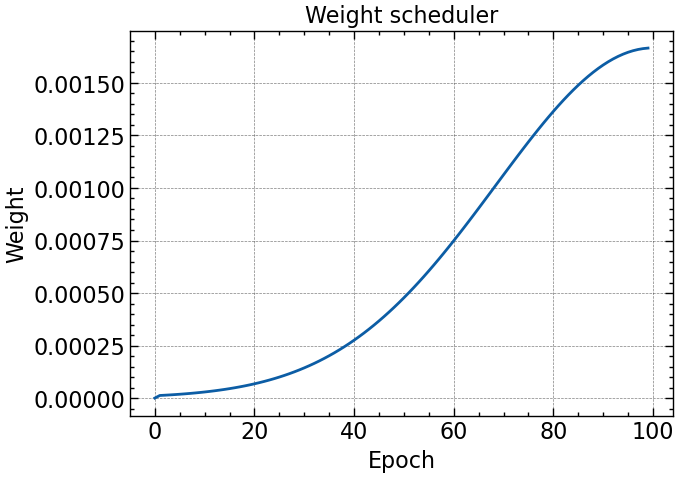

In [146]:
def weight_scheduler(epoch, max_epochs, max_val, mult, n_labeled, n_samples):
    max_val = max_val * (float(n_labeled) / n_samples)
    if epoch == 0:
        return 0.
    elif epoch >= max_epochs:
        pass
    return max_val * np.exp(-mult * (1. - float(epoch) / max_epochs) ** 2)
    
max_epochs = 100
max_val = 1.
mult = 5

x = np.arange(0, 100)
y = [weight_scheduler(i, max_epochs, max_val, mult, 100, 60000) for i in x]
plt.figure(figsize=(7, 5))
plt.plot(x, y)
plt.xlabel('Epoch')
plt.ylabel('Weight')
plt.title('Weight scheduler');


Weight ramp up function 은 시작을 0으로 Epoch 이 진행될수록 단조증가하는 함수이다. 

$\exp(-(1 - \frac{epoch}{maxepochs})^2)$

In [138]:
class CNN(nn.Module):
    def __init__(self, batch_size, std, input_shape=(1, 28, 28), p=0.5, fm1=16, fm2=32):
        super(CNN, self).__init__()
        self.std = std
        self.p = p
        self.fm1 = fm1
        self.fm2 = fm2
        self.input_shape = input_shape
        self.conv_block1 = nn.Sequential(nn.Conv2d(1, self.fm1, 3, stride=1, padding=1),
                                        nn.BatchNorm2d(self.fm1), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(3, stride=2, padding=1)
                                      )
        
        self.conv_block2 = nn.Sequential(nn.Conv2d(self.fm1, self.fm2, 3, stride=1, padding=1),
                                        nn.BatchNorm2d(self.fm2), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(3, stride=2, padding=1)
                                      )
        self.drop = nn.Dropout(self.p)
        self.fc = nn.Linear(self.fm2 * 7 * 7, 10)

    def forward(self, x):
        if self.training:
            b = x.size(0)
            gn = GaussianNoise(b, self.input_shape, self.std)
            x = gn(x)

        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(-1, self.fm2 * 7 * 7)
        x = self.fc(self.drop(x))
        return x

실제로 학습할 모델 구조는 이미지 데이터에 걸맞는 CNN 구조를 선택하였다. 각 샘플에 대해 이전에 정의한 `GaussianNoise` 클래스를 통해 perturbation 을 주입하기 위한 인자 `std` 와, 마지막 affine층에 dropout 확률을 조절할 수 있는 인자 `p` 를 정의하였다.

모델 구조는 2개의 convolutional block 과 1개의 affine layer 로 구성되어 있으며, 각 convolutional block 은 2차원 convolution, batch normalization, ReLU 활성화, 그리고 2차원 max pooling 으로 구성하였다.

학습 시에는 input 데이터에 대해 가우시안 perturbation을 진행 한 뒤, 순전파를 거친다.

In [147]:
def calc_metrics(model, loader):
    correct = 0
    total = 0
    for i, (samples, labels) in enumerate(loader):
        labels = labels.requires_grad_(False)
        outputs = model(samples)
        _, predicted = torch.max(outputs.detach(), 1)
        total += labels.size(0)
        correct += (predicted == labels.detach().view_as(predicted)).sum()
    acc = 100 * float(correct) / total
    return acc

def train(model, train_loader, val_loader ,seed, k, alpha, lr, num_epochs, batch_size, ntrain,n_classes=10, max_epochs=80, max_val=1.):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))

    Z = torch.zeros(ntrain, n_classes).float()
    z = torch.zeros(ntrain, n_classes).float()
    outputs = torch.zeros(ntrain, n_classes).float()

    losses = []
    suplosses = []
    unsuplosses = []
    best_loss = 30.0
    for epoch in range(num_epochs):
        
        print(f'\nEpoch: {epoch+1}')
        model.train()
        w = weight_scheduler(epoch, max_epochs, max_val, 5, k, 60000)

        w = torch.tensor(w, requires_grad=False)
        print('---------------------')

        for i, (images, labels) in tqdm(enumerate(train_loader)):
            batch_size = images.size(0)
            images = images
            labels = labels.requires_grad_(False)

            optimizer.zero_grad()
            out = model(images)
            
            zcomp = z[i * batch_size: (i+1) * batch_size]
            zcomp.requires_grad_(False)
            loss, suploss, unsuploss, nbsup = temporal_losses(out, zcomp, w, labels)

            outputs[i * batch_size: (i+1) * batch_size] = out.clone().detach()
            losses.append(loss.item())
            suplosses.append(nbsup * suploss.item())
            unsuplosses.append(unsuploss.item())

            loss.backward()
            optimizer.step()

        loss_mean = np.mean(losses)
        supl_mean = np.mean(suplosses)
        unsupl_mean = np.mean(unsuplosses)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss_mean:.6f}, Supervised Loss: {supl_mean:.6f}, Unsupervised Loss: {unsupl_mean:.6f}')
        Z = alpha * Z + (1. - alpha) * outputs
        z = Z * (1. / (1. - alpha ** (epoch + 1)))

        if loss_mean < best_loss:
            best_loss = loss_mean
            torch.save({'state_dict': model.state_dict()}, 'model_best.pth')

        model.eval()
        acc = calc_metrics(model, val_loader)
        print(f'Acc : {acc}')

Temporal Ensembling 의 학습을 위한 함수를 정의하였다.
첫 epoch 에는 reference 할 $Z$ 가 없기 때문에 먼저 0으로 초기화를 해주었다.
```
Z = torch.zeros(ntrain, n_classes).float()
z = torch.zeros(ntrain, n_classes).float()
```
이후 한 epoch 이 지난 후, $\alpha Z + (1-\alpha)z$ 로 $Z$ 를 업데이트 해준 뒤, 다음 epoch 에서 target 으로 사용할 $z$ 를 $Z/(1-\alpha^t)$ 가중평균으로 업데이트 해주었다.

```
Z = alpha * Z + (1. - alpha) * outputs
z = Z * (1. / (1. - alpha ** (epoch + 1)))
```

In [142]:
model = CNN(batch_size=64, std=0.1)
train(model, train_loader, test_loader,
        seed=0, k=100, alpha=0.6, lr=0.002,
        num_epochs=50, batch_size=64, ntrain=(len(train_data)))


Epoch: 1
---------------------


0it [00:00, ?it/s]

Epoch 1/50, Loss: 0.482498, Supervised Loss: 0.487168, Unsupervised Loss: 0.055183
Acc : 50.54

Epoch: 2
---------------------


0it [00:00, ?it/s]

Epoch 2/50, Loss: 0.355230, Supervised Loss: 0.358557, Unsupervised Loss: 0.054616
Acc : 56.86

Epoch: 3
---------------------


0it [00:00, ?it/s]

Epoch 3/50, Loss: 0.281673, Supervised Loss: 0.284004, Unsupervised Loss: 0.048527
Acc : 63.20

Epoch: 4
---------------------


0it [00:00, ?it/s]

Epoch 4/50, Loss: 0.240190, Supervised Loss: 0.242011, Unsupervised Loss: 0.042495
Acc : 61.59

Epoch: 5
---------------------


0it [00:00, ?it/s]

Epoch 5/50, Loss: 0.211269, Supervised Loss: 0.212726, Unsupervised Loss: 0.038273
Acc : 61.90

Epoch: 6
---------------------


0it [00:00, ?it/s]

Epoch 6/50, Loss: 0.189089, Supervised Loss: 0.190377, Unsupervised Loss: 0.035337
Acc : 60.49

Epoch: 7
---------------------


0it [00:00, ?it/s]

Epoch 7/50, Loss: 0.171863, Supervised Loss: 0.172973, Unsupervised Loss: 0.032965
Acc : 62.70

Epoch: 8
---------------------


0it [00:00, ?it/s]

Epoch 8/50, Loss: 0.155320, Supervised Loss: 0.156492, Unsupervised Loss: 0.031299
Acc : 66.48

Epoch: 9
---------------------


0it [00:00, ?it/s]

Epoch 9/50, Loss: 0.143544, Supervised Loss: 0.144587, Unsupervised Loss: 0.030113
Acc : 66.92

Epoch: 10
---------------------


0it [00:00, ?it/s]

Epoch 10/50, Loss: 0.134025, Supervised Loss: 0.134964, Unsupervised Loss: 0.029217
Acc : 65.49

Epoch: 11
---------------------


0it [00:00, ?it/s]

Epoch 11/50, Loss: 0.127086, Supervised Loss: 0.127940, Unsupervised Loss: 0.028382
Acc : 66.17

Epoch: 12
---------------------


0it [00:00, ?it/s]

Epoch 12/50, Loss: 0.119365, Supervised Loss: 0.120147, Unsupervised Loss: 0.027469
Acc : 64.47

Epoch: 13
---------------------


0it [00:00, ?it/s]

Epoch 13/50, Loss: 0.112159, Supervised Loss: 0.112883, Unsupervised Loss: 0.027187
Acc : 65.78

Epoch: 14
---------------------


0it [00:00, ?it/s]

Epoch 14/50, Loss: 0.106423, Supervised Loss: 0.107095, Unsupervised Loss: 0.026904
Acc : 66.40

Epoch: 15
---------------------


0it [00:00, ?it/s]

Epoch 15/50, Loss: 0.100988, Supervised Loss: 0.101615, Unsupervised Loss: 0.026676
Acc : 65.06

Epoch: 16
---------------------


0it [00:00, ?it/s]

Epoch 16/50, Loss: 0.096885, Supervised Loss: 0.097473, Unsupervised Loss: 0.026318
Acc : 63.29

Epoch: 17
---------------------


0it [00:00, ?it/s]

Epoch 17/50, Loss: 0.092693, Supervised Loss: 0.093246, Unsupervised Loss: 0.025886
Acc : 66.87

Epoch: 18
---------------------


0it [00:00, ?it/s]

Epoch 18/50, Loss: 0.088357, Supervised Loss: 0.088880, Unsupervised Loss: 0.025517
Acc : 66.37

Epoch: 19
---------------------


0it [00:00, ?it/s]

Epoch 19/50, Loss: 0.083829, Supervised Loss: 0.084325, Unsupervised Loss: 0.025255
Acc : 68.22

Epoch: 20
---------------------


0it [00:00, ?it/s]

Epoch 20/50, Loss: 0.080189, Supervised Loss: 0.080661, Unsupervised Loss: 0.024940
Acc : 67.99

Epoch: 21
---------------------


0it [00:00, ?it/s]

Epoch 21/50, Loss: 0.077457, Supervised Loss: 0.077909, Unsupervised Loss: 0.024711
Acc : 67.05

Epoch: 22
---------------------


0it [00:00, ?it/s]

Epoch 22/50, Loss: 0.074355, Supervised Loss: 0.074786, Unsupervised Loss: 0.024612
Acc : 69.16

Epoch: 23
---------------------


0it [00:00, ?it/s]

Epoch 23/50, Loss: 0.071668, Supervised Loss: 0.072080, Unsupervised Loss: 0.024432
Acc : 67.70

Epoch: 24
---------------------


0it [00:00, ?it/s]

Epoch 24/50, Loss: 0.069339, Supervised Loss: 0.069734, Unsupervised Loss: 0.024344
Acc : 68.31

Epoch: 25
---------------------


0it [00:00, ?it/s]

Epoch 25/50, Loss: 0.067561, Supervised Loss: 0.067940, Unsupervised Loss: 0.024132
Acc : 67.22

Epoch: 26
---------------------


0it [00:00, ?it/s]

Epoch 26/50, Loss: 0.065487, Supervised Loss: 0.065851, Unsupervised Loss: 0.024006
Acc : 68.34

Epoch: 27
---------------------


0it [00:00, ?it/s]

Epoch 27/50, Loss: 0.063323, Supervised Loss: 0.063674, Unsupervised Loss: 0.023786
Acc : 70.16

Epoch: 28
---------------------


0it [00:00, ?it/s]

Epoch 28/50, Loss: 0.061311, Supervised Loss: 0.061649, Unsupervised Loss: 0.023599
Acc : 69.48

Epoch: 29
---------------------


0it [00:00, ?it/s]

Epoch 29/50, Loss: 0.059209, Supervised Loss: 0.059535, Unsupervised Loss: 0.023399
Acc : 68.41

Epoch: 30
---------------------


0it [00:00, ?it/s]

Epoch 30/50, Loss: 0.057282, Supervised Loss: 0.057597, Unsupervised Loss: 0.023254
Acc : 68.89

Epoch: 31
---------------------


0it [00:00, ?it/s]

Epoch 31/50, Loss: 0.056423, Supervised Loss: 0.056728, Unsupervised Loss: 0.023162
Acc : 68.52

Epoch: 32
---------------------


0it [00:00, ?it/s]

Epoch 32/50, Loss: 0.054668, Supervised Loss: 0.054963, Unsupervised Loss: 0.023067
Acc : 68.54

Epoch: 33
---------------------


0it [00:00, ?it/s]

Epoch 33/50, Loss: 0.053294, Supervised Loss: 0.053581, Unsupervised Loss: 0.023001
Acc : 68.85

Epoch: 34
---------------------


0it [00:00, ?it/s]

Epoch 34/50, Loss: 0.051733, Supervised Loss: 0.052011, Unsupervised Loss: 0.022857
Acc : 68.89

Epoch: 35
---------------------


0it [00:00, ?it/s]

Epoch 35/50, Loss: 0.051040, Supervised Loss: 0.051310, Unsupervised Loss: 0.022779
Acc : 68.74

Epoch: 36
---------------------


0it [00:00, ?it/s]

Epoch 36/50, Loss: 0.050279, Supervised Loss: 0.050541, Unsupervised Loss: 0.022702
Acc : 69.27

Epoch: 37
---------------------


0it [00:00, ?it/s]

Epoch 37/50, Loss: 0.049077, Supervised Loss: 0.049331, Unsupervised Loss: 0.022558
Acc : 69.55

Epoch: 38
---------------------


0it [00:00, ?it/s]

Epoch 38/50, Loss: 0.047787, Supervised Loss: 0.048035, Unsupervised Loss: 0.022379
Acc : 69.00

Epoch: 39
---------------------


0it [00:00, ?it/s]

Epoch 39/50, Loss: 0.046564, Supervised Loss: 0.046805, Unsupervised Loss: 0.022230
Acc : 69.36

Epoch: 40
---------------------


0it [00:00, ?it/s]

Epoch 40/50, Loss: 0.045401, Supervised Loss: 0.045636, Unsupervised Loss: 0.022060
Acc : 68.84

Epoch: 41
---------------------


0it [00:00, ?it/s]

Epoch 41/50, Loss: 0.045661, Supervised Loss: 0.045890, Unsupervised Loss: 0.021963
Acc : 69.80

Epoch: 42
---------------------


0it [00:00, ?it/s]

Epoch 42/50, Loss: 0.045076, Supervised Loss: 0.045299, Unsupervised Loss: 0.021853
Acc : 69.58

Epoch: 43
---------------------


0it [00:00, ?it/s]

Epoch 43/50, Loss: 0.044570, Supervised Loss: 0.044788, Unsupervised Loss: 0.021755
Acc : 68.92

Epoch: 44
---------------------


0it [00:00, ?it/s]

Epoch 44/50, Loss: 0.044082, Supervised Loss: 0.044295, Unsupervised Loss: 0.021668
Acc : 69.65

Epoch: 45
---------------------


0it [00:00, ?it/s]

Epoch 45/50, Loss: 0.044167, Supervised Loss: 0.044375, Unsupervised Loss: 0.021607
Acc : 69.75

Epoch: 46
---------------------


0it [00:00, ?it/s]

Epoch 46/50, Loss: 0.043499, Supervised Loss: 0.043701, Unsupervised Loss: 0.021524
Acc : 69.55

Epoch: 47
---------------------


0it [00:00, ?it/s]

Epoch 47/50, Loss: 0.043408, Supervised Loss: 0.043607, Unsupervised Loss: 0.021410
Acc : 69.73

Epoch: 48
---------------------


0it [00:00, ?it/s]

Epoch 48/50, Loss: 0.042939, Supervised Loss: 0.043133, Unsupervised Loss: 0.021320
Acc : 69.56

Epoch: 49
---------------------


0it [00:00, ?it/s]

Epoch 49/50, Loss: 0.042734, Supervised Loss: 0.042924, Unsupervised Loss: 0.021248
Acc : 69.19

Epoch: 50
---------------------


0it [00:00, ?it/s]

Epoch 50/50, Loss: 0.041942, Supervised Loss: 0.042128, Unsupervised Loss: 0.021125
Acc : 68.77


$z$ 의 가중평균 momentum $\alpha = 0.6$, learning rate 0.002, batch size 64 로 총 50 epoch 동안 학습을 진행하였다.

`model.device` 를 따로 할당하지 않고 일반 cpu 에서 학습 한 결과 약 20분이 걸렸으며, 최종적인 Accuracy 는 약 68.77 였다.

In [187]:
def evaluation(model, loader):
    checkpoint = torch.load('model_best.pth')
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    correct = 0
    total = 0
    pred_probs = []
    true_labels = []
    with torch.inference_mode():
        for i, (samples, labels) in enumerate(loader):
            labels = labels.requires_grad_(False)
            outputs = model(samples)
            _, predicted = torch.max(outputs.detach(), 1)
            total += labels.size(0)
            correct += (predicted == labels.detach().view_as(predicted)).sum()
            pred_probs.append(predicted)
            true_labels.append(labels)
        acc = 100 * float(correct) / total
        print(f'Testing Accuracy: {acc:.1f}')
        pred_probs = torch.cat(pred_probs)
        labels = torch.cat(true_labels)
    return pred_probs, labels

pred_probs, labels = evaluation(model, test_loader)

Testing Accuracy: 68.8


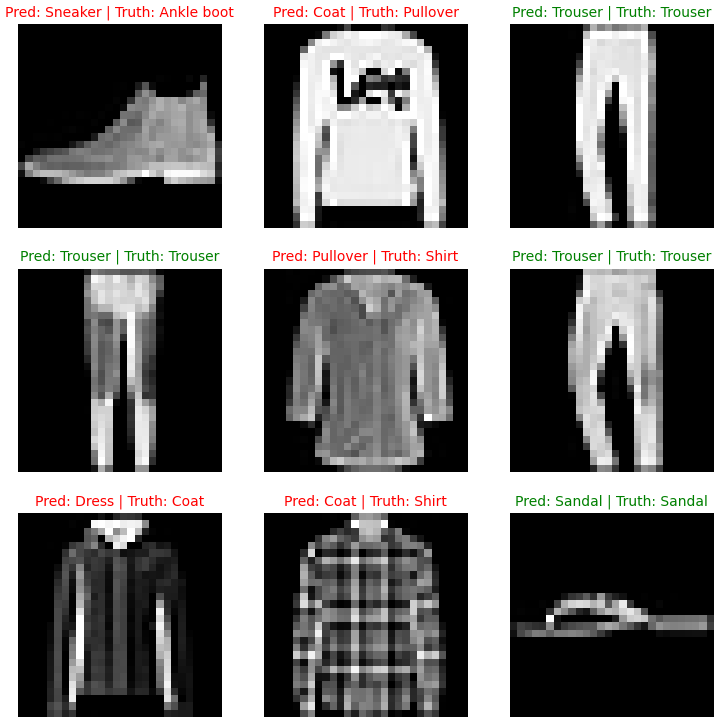

In [186]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_data):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample[0].squeeze(), cmap="gray")
    pred_label = class_names[pred_probs[i]]
    truth_label = class_names[labels[i]] 
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
        plt.axis(False);
    else:
        plt.title(title_text, fontsize=10, c="r")
        plt.axis(False);
    if i==8:
        break

Test 데이터에 대한 Accuracy 는 약 68.8로, 일반적인 classification task 였으면 sub-par 한 성능이였겠지만, **총 60,000개의 학습 샘플 중 100개만 label 이 있다는 것을 감안 한다면 꽤나 준수한 성능을 보인 것을 알 수 있다.**